In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 2013-14_Filtered.csv to 2013-14_Filtered.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

In [ ]:
# Load the data
df = pd.read_csv('2013-14_Filtered.csv')

# Basic information
print("Data Info:")
df.info()
print("\nMissing values:\n", df.isnull().sum())

<ipython-input-16-93083e5e99e1>:2: DtypeWarning: Columns (18,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('2013-14_Filtered.csv')


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403697 entries, 0 to 403696
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   403697 non-null  int64  
 1   id                           403697 non-null  int64  
 2   member_id                    403697 non-null  int64  
 3   loan_amnt                    403697 non-null  int64  
 4   funded_amnt                  403697 non-null  int64  
 5   funded_amnt_inv              403697 non-null  float64
 6   term                         403697 non-null  object 
 7   int_rate                     403697 non-null  float64
 8   installment                  403697 non-null  float64
 9   grade                        403697 non-null  object 
 10  sub_grade                    403697 non-null  object 
 11  emp_title                    380989 non-null  object 
 12  emp_length                   381038 non-null  o

In [ ]:
# Show actual column names to identify the correct target column
print("\nColumn names in the dataset:")
print(df.columns.tolist())


Column names in the dataset:
['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', '

In [ ]:
# Drop columns with excessive missing values (if any threshold-based)
threshold = 0.5
df = df[df.columns[df.isnull().mean() < threshold]]

# Fill missing values
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].median())

In [ ]:
# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
# Set the correct target variable name from the dataset
target = 'default_ind'
X = df.drop(columns=[target])
y = df[target]

In [ ]:
# Calculate and remove features with high VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif = calculate_vif(X)
print("\nVIF Scores:\n", vif)
low_vif_features = vif.loc[vif['VIF'] < 10, 'feature']
X = X[low_vif_features]  # Use only features with low VIF

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF Scores:
                        feature           VIF
0                   Unnamed: 0  8.811056e+01
1                           id  2.049557e+02
2                    member_id  1.955326e+02
3                    loan_amnt           inf
4                  funded_amnt           inf
5              funded_amnt_inv  1.475115e+07
6                         term  8.132754e+00
7                     int_rate  1.746633e+02
8                  installment  4.799882e+01
9                        grade  2.094982e+01
10                   sub_grade  1.966369e+02
11                   emp_title  1.015203e+00
12                  emp_length  1.017172e+00
13              home_ownership  1.389580e+00
14                  annual_inc  1.280689e+00
15         verification_status  1.161916e+00
16                     issue_d  8.805189e+01
17                  pymnt_plan  1.000078e+00
18                     purpose  3.982886e+00
19                       title  3.871639e+00
20                    zip_code  1.067435e

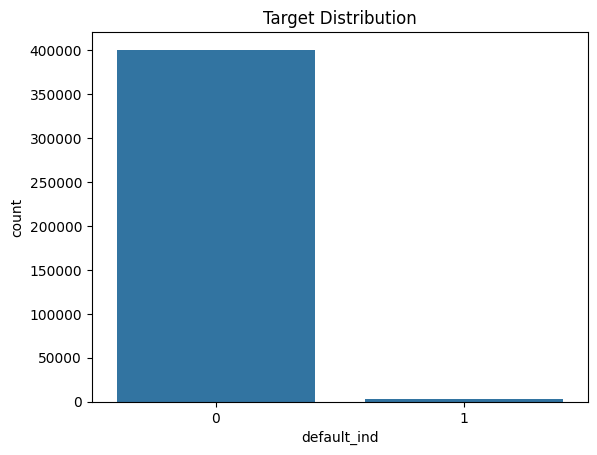

In [ ]:
# Check for class imbalance
sns.countplot(x=y)
plt.title("Target Distribution")
plt.show()

In [ ]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train a Random Forest with class_weight balanced and preset params
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Predict probabilities and adjust threshold
y_probs = model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.3  # Adjust threshold as needed
y_pred = (y_probs >= threshold).astype(int)

In [ ]:
# Evaluation
print(f"\nAdjusted Threshold = {threshold}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Adjusted Threshold = 0.3

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     80108
           1       0.89      0.92      0.91       632

    accuracy                           1.00     80740
   macro avg       0.95      0.96      0.95     80740
weighted avg       1.00      1.00      1.00     80740


Confusion Matrix:
 [[80039    69]
 [   51   581]]


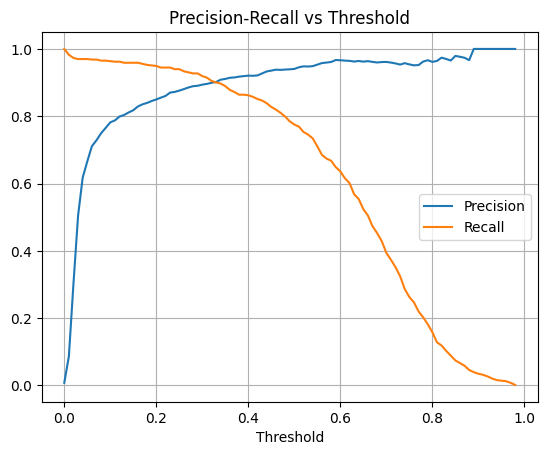

In [ ]:
# Precision-Recall vs Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Cross-validation to check overfitting
cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
print("\nCross-validated F1 scores:", cv_scores)
print("Average F1 score:", np.mean(cv_scores))


Cross-validated F1 scores: [0.70684372 0.82089552 0.85586392 0.85714286 0.83043478]
Average F1 score: 0.8142361602873665


In [ ]:
# Feature Importance
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

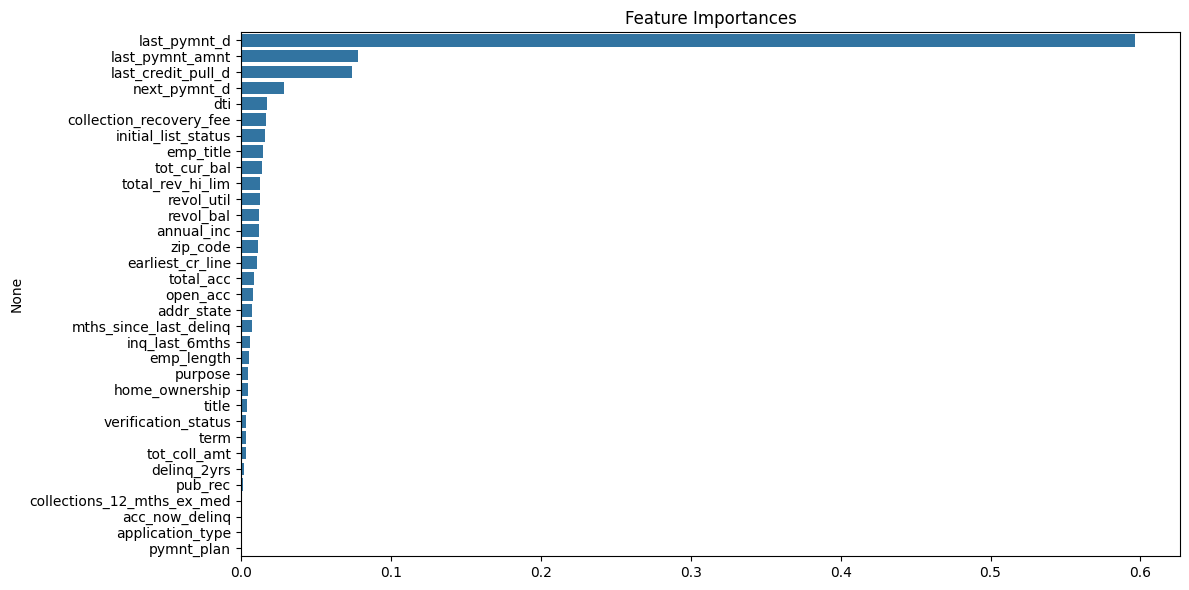

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=1,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)
y_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
# Optimal threshold search for XGBoost
t_best_f1, t_best_thresh = 0, 0.5
for t in np.arange(0.1, 0.9, 0.01):
    score = f1_score(y_test, (y_probs >= t).astype(int))
    if score > t_best_f1:
        t_best_f1, t_best_thresh = score, t
print(f"\nnew! ver.(1): XGBoost Optimal Threshold: {t_best_thresh}, Best F1: {t_best_f1:.4f}")


new! ver.(1): XGBoost Optimal Threshold: 0.32999999999999985, Best F1: 0.9227


In [ ]:
y_pred = (y_probs >= t_best_thresh).astype(int)
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred))
print("\nXGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     80108
           1       0.91      0.94      0.92       632

    accuracy                           1.00     80740
   macro avg       0.96      0.97      0.96     80740
weighted avg       1.00      1.00      1.00     80740


XGBoost Confusion Matrix:
 [[80050    58]
 [   41   591]]


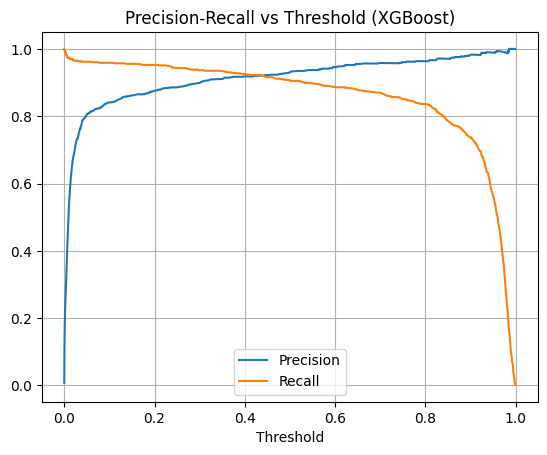

In [ ]:
# Precision-Recall vs Threshold for XGBoost
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.title('Precision-Recall vs Threshold (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Cross-validation on XGBoost
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='f1')
print("\nXGBoost Cross-validated F1 scores:", cv_scores)
print("Average F1 score:", np.mean(cv_scores))


XGBoost Cross-validated F1 scores: [0.53233565 0.95559211 0.95153473 0.91717791 0.82629108]
Average F1 score: 0.8365862964024368


In [ ]:
# Feature Importance from XGBoost
importances = xgb_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

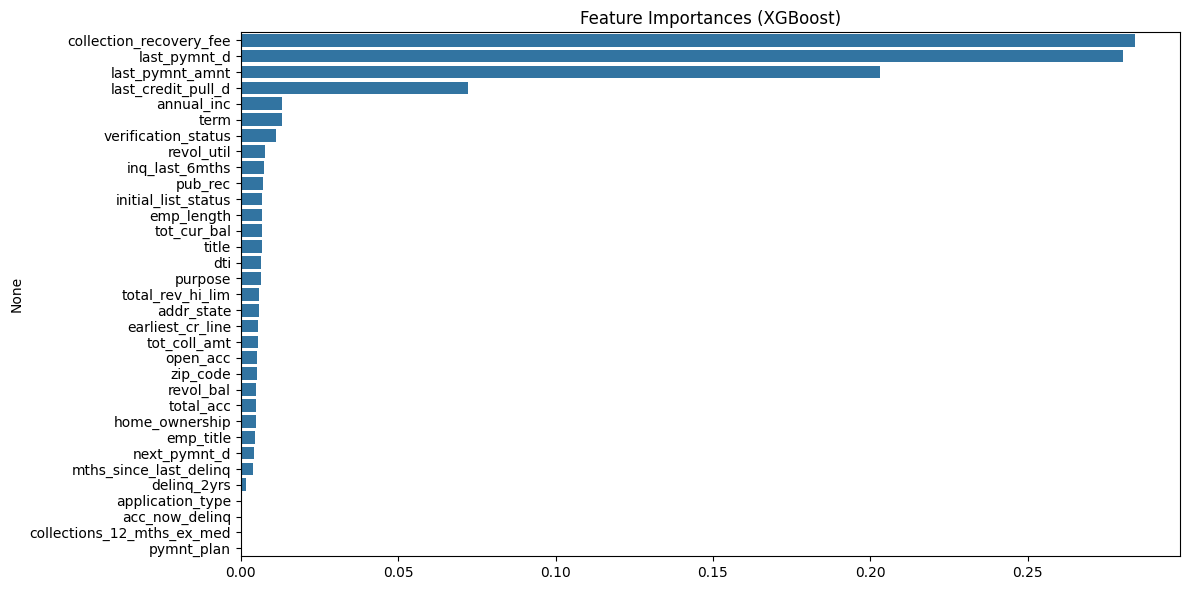

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title('Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

# Classification Report Analysis

Class 0 (majority class):

Very high performance: perfect scores (precision, recall, F1-score = 1.00)

Class 1 (minority class):

Precision = 0.89: Out of all predicted positives, 89% were correct.

Recall = 0.92: Out of all actual positives, 92% were correctly identified.

F1-score = 0.91: A good balance between precision and recall.

#  Overall Metrics
Accuracy: 98% (high overall performance, but may be biased due to class imbalance)

Macro Avg: Averages metrics equally across classes (still high, indicating good performance on minority class too)

Weighted Avg: Accounts for support (number of samples), also very high due to dominance of class 0



# Conclusion & Insight
Your model performs exceptionally well, especially after adjusting the threshold to 0.3.

High recall for class 1 (minority) is crucial if missing positives is costly (e.g., fraud detection, medical diagnosis).

The adjusted threshold helped balance the performance between both classes.